$$\require{cancel}$$

In [15]:
from IPython.display import display, Javascript, HTML
display(HTML("<style>.jp-Notebook { width: 85% !important; }</style>"))

#### Hack för att bli av med ful-cellerna vid export till HTML ####
# Tagga med hide-cell, sen lägg till i den genererade html-filen i <style>:
# div.celltag_hide-cell {display: none;}


In [14]:
%%html
<style>
.jp-CodeCell .jp-Editor,
.jp-RenderedHTMLCommon {
    font-size: 20px;
}
.jp-CodeCell .jp-InputArea-editor {
    font-size: 20px;
}
</style>

## Mitt första neurala nätverk ##
##### Linjär regression utan aktiveringsfunktion #####

Installera grafritar-paketet

In [5]:
!pip install graphviz

In [6]:
import graphviz

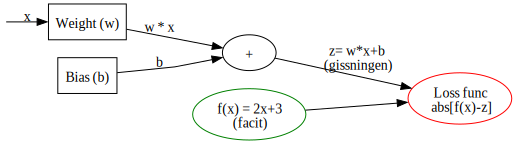

In [7]:
G='''
digraph G {
    rankdir=LR;
    splines=polyline;

    // Nodes
    input [label="", width=0, height=0, style=invis];
    weight [label="Weight (w)", shape=box];
    bias [label="Bias (b)", shape=box];
    Zum [label="+", shape=ellipse];
    loss [label=<Loss func<br/>abs[f(x)-z]>, shape=oval, color=red];
    facit [label=<f(x) = 2x+3<br/>(facit)>, shape=oval, color=green];

    // Edges
    input -> weight [label="x"];
    weight -> Zum [label="w * x"];
    bias -> Zum [label="b"];
    Zum -> loss [label=<z= w*x+b<br/>(gissningen)>];
    facit -> loss
    
}
'''
graphviz.Source(G)


##### Så här ser det ut, nätverket vi kommer att implementera. #####

Vi kommer att:   
* Slumpa en massa input (x)
* Köra dem igenom nätverket en och en, och få ett resultat **z**
* Skapa en "rätta svaret"-funktion, facit (y = 3x + 2) el. likn, så att vi vet vad z _borde_ ha blivit 
* Jämföra varje **z** med facit
* Beräkna felet och utifrån det ...
* Justera vikterna **w** och **b** nedan


Nu kör vi framåt genom nätverket ovan, fast med kod.   

... men vi börjar med **ett enda** input av x, för att till sist automatisera processen

In [1]:
import random
random.seed(42)

In [2]:
def facit(x):
    return 3*x + 2

In [3]:
x=random.uniform(-1,1)*5  #slumptal från -5 .. 5

In [4]:
x

1.3942679845788375

In [5]:

w=random.uniform(-1,1)   
b=random.uniform(-1,1)
    

In [6]:
w

-0.9499784895546661

In [7]:
b

-0.4499413632617615

In [8]:
z = w*x+b

In [9]:
z

-1.7744659572863941

z, som är vår gissning ska jämföras med vårt facit ( 2x+3 ) från ovan för att kolla hur bra den var.

Vi använder avståndet till det rätta svaret som mått på felet. Och för att inte sen när vi justerar **vikt** och **bias** nätverket får spel o  åker rakt ut för stupet till plus eller minus oändligheten behöver vi en funktion som har ett minimum som vi kan försöka nå med lite smarta metoder. Här tar vi funktionen f(x) = abs(x). Se nedan

Först lite paket för att räkna o plotta, så vi bättre kan se

In [10]:
!pip install numpy

In [8]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.6 MB/s eta 0:00:0000:0100:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


Här är en principiel graph på Loss-funktionen. Facit är = 2 här, och vår gissning (z) på -2.5 ger ett fel på ca 4.    

Grafen visar hur långt ifrån detta minimum vi hamnar för varje z mellan -5 .. 10. 

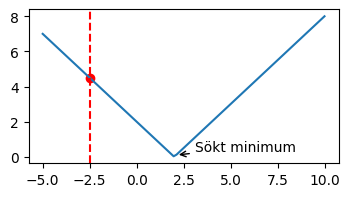

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n = 100
gissn = np.linspace(-5, 10, n)
fct = np.ones(n)*2
Loss = np.abs(fct - gissn)


plt.figure(figsize=(4, 2))
plt.plot(gissn, Loss, label="f(x) = |facit - gissn|")
annotation_x = 2.1
annotation_y = 0.1
plt.annotate(
    "Sökt minimum",
    xy=(annotation_x, annotation_y),
    xytext=(annotation_x + 1, annotation_y + 0.2),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
)

x_value = -2.5
y_value = np.abs(2 - x_value)
plt.axvline(x=x_value, ymin=0, ymax=y_value, linestyle='--', color='red')

# Anta att detta är vår gissning
plt.scatter(x_value, y_value, color='red', marker='o')

plt.show()

#from IPython.display import HTML
#HTML('<button onclick="hide_single_input(this)">Toggle this code cell</button>')


Här är felet (Loss) mer än fyra, och vi måste se till att vår gissning blir större nästa gång, så att felet kan minska.  

Detta vet vi eftersom lutningen på linjen där gissningen träffar, är negativ. Och detta vet vi, i sin tur, p.g.a att vi känner till både funktionens definition _och_ det rätta svaret.   

_(längre ner ser du hur vi låter datorn beräkna riktningskoefficienten beroende på gissning,  för just vårt nätverk blir det väldigt enkelt: Antingen -1 eller 1)_

Det är p.g.a *denna* insikt som vi använder oss av en loss-funktion med ett väldefinierat minimum. Ibland använder man andragrads-funktioner, som ju också har ett minimum, till detta.  

Vi fortsätter, och definierar Loss funktionen i vår kod

In [13]:
def abs_loss(facit, z):
    return abs(facit - z)

In [14]:
facit = facit(x)

In [15]:
facit

6.182803953736513

In [16]:
loss = abs_loss(facit, z)

In [17]:
loss

7.957269911022907

Oj, det var t.o.m större än i grafen ovan. Nu ska vi som sagt försöka minska det. Genom "back propagation".   

Man går helt enkelt baklänges igenom grafen och räknar ut hur mycket ändring det måste ske i vikt och bias - *samt alla de saker på vägen som vanligtvis ligger mellan lossFunktionen och början på nätverket* - för att felet ska minskas med värdet ovan. 

In [18]:
#Learning rate är nåt som dämpar lite, annars kan de lätt gå överstyr 
learning_rate = 0.01

# Baklänges pass - beräkna den totala gradienten / lutningen m.h.a kedjeregeln
dLoss_dyGiss = 1 if z > facit else -1
dLoss_dw = dLoss_dyGiss * x
dLoss_db = dLoss_dyGiss

# Uppdatera våra paramnetrar, så vi kan köra igen, och igen ... och ..
w -= learning_rate * dLoss_dw
b -= learning_rate * dLoss_db

Denna föregående kodruta är **hjärtat** av maskininlärning. Back Propagation görs m.h.a derivata och kedjeregeln, men eftersom matten inte hunnit dit än kör vi denna model, som faktiskt kan förklaras och förstås genom lite ritande o grublande   

*Vi tar dettta gemensamt i klassen, så alla kan förstå*

**Men** även om du fattar noll just nu av vad den gör, så räcker det för dig att veta att i slutändan produceras/justeras de enda två justerbara parametrarna vi har i vårt nätverk, nämligen **w** och **b**. Dessa ska användas för att göra om allt igen

In [19]:
w

-0.9360358097088778

In [20]:
b

-0.4399413632617615

Det är inte mycket till skillnad från hur de var från början, men vi har sett till att förändringen går åt rätt håll.   


#### Slutmål ####

Nu är det upp till dig att fortsätta denna uppgift och göra en tränings-loop så du kan automatisera ovanstående process, och köra den några hundra gånger.   

Om allt går bra bör **w -> 3** och **b->2** till slut, ifall nätverket lyckats "härma" den sanna funktionen y = 3x + 2



Tänk på samma sätt som med bilen. I vår kod är det ännu något enklare, med bara en multiplikation av rikningskoefficienter. Man måste å andra sidan göra det för både vikt såväl som bias 

Om detta är för mycket att bita i meddetsamma, så hoppa till övningarna nedan.

#### Enkelt Exempel på Kedjeregeln ####

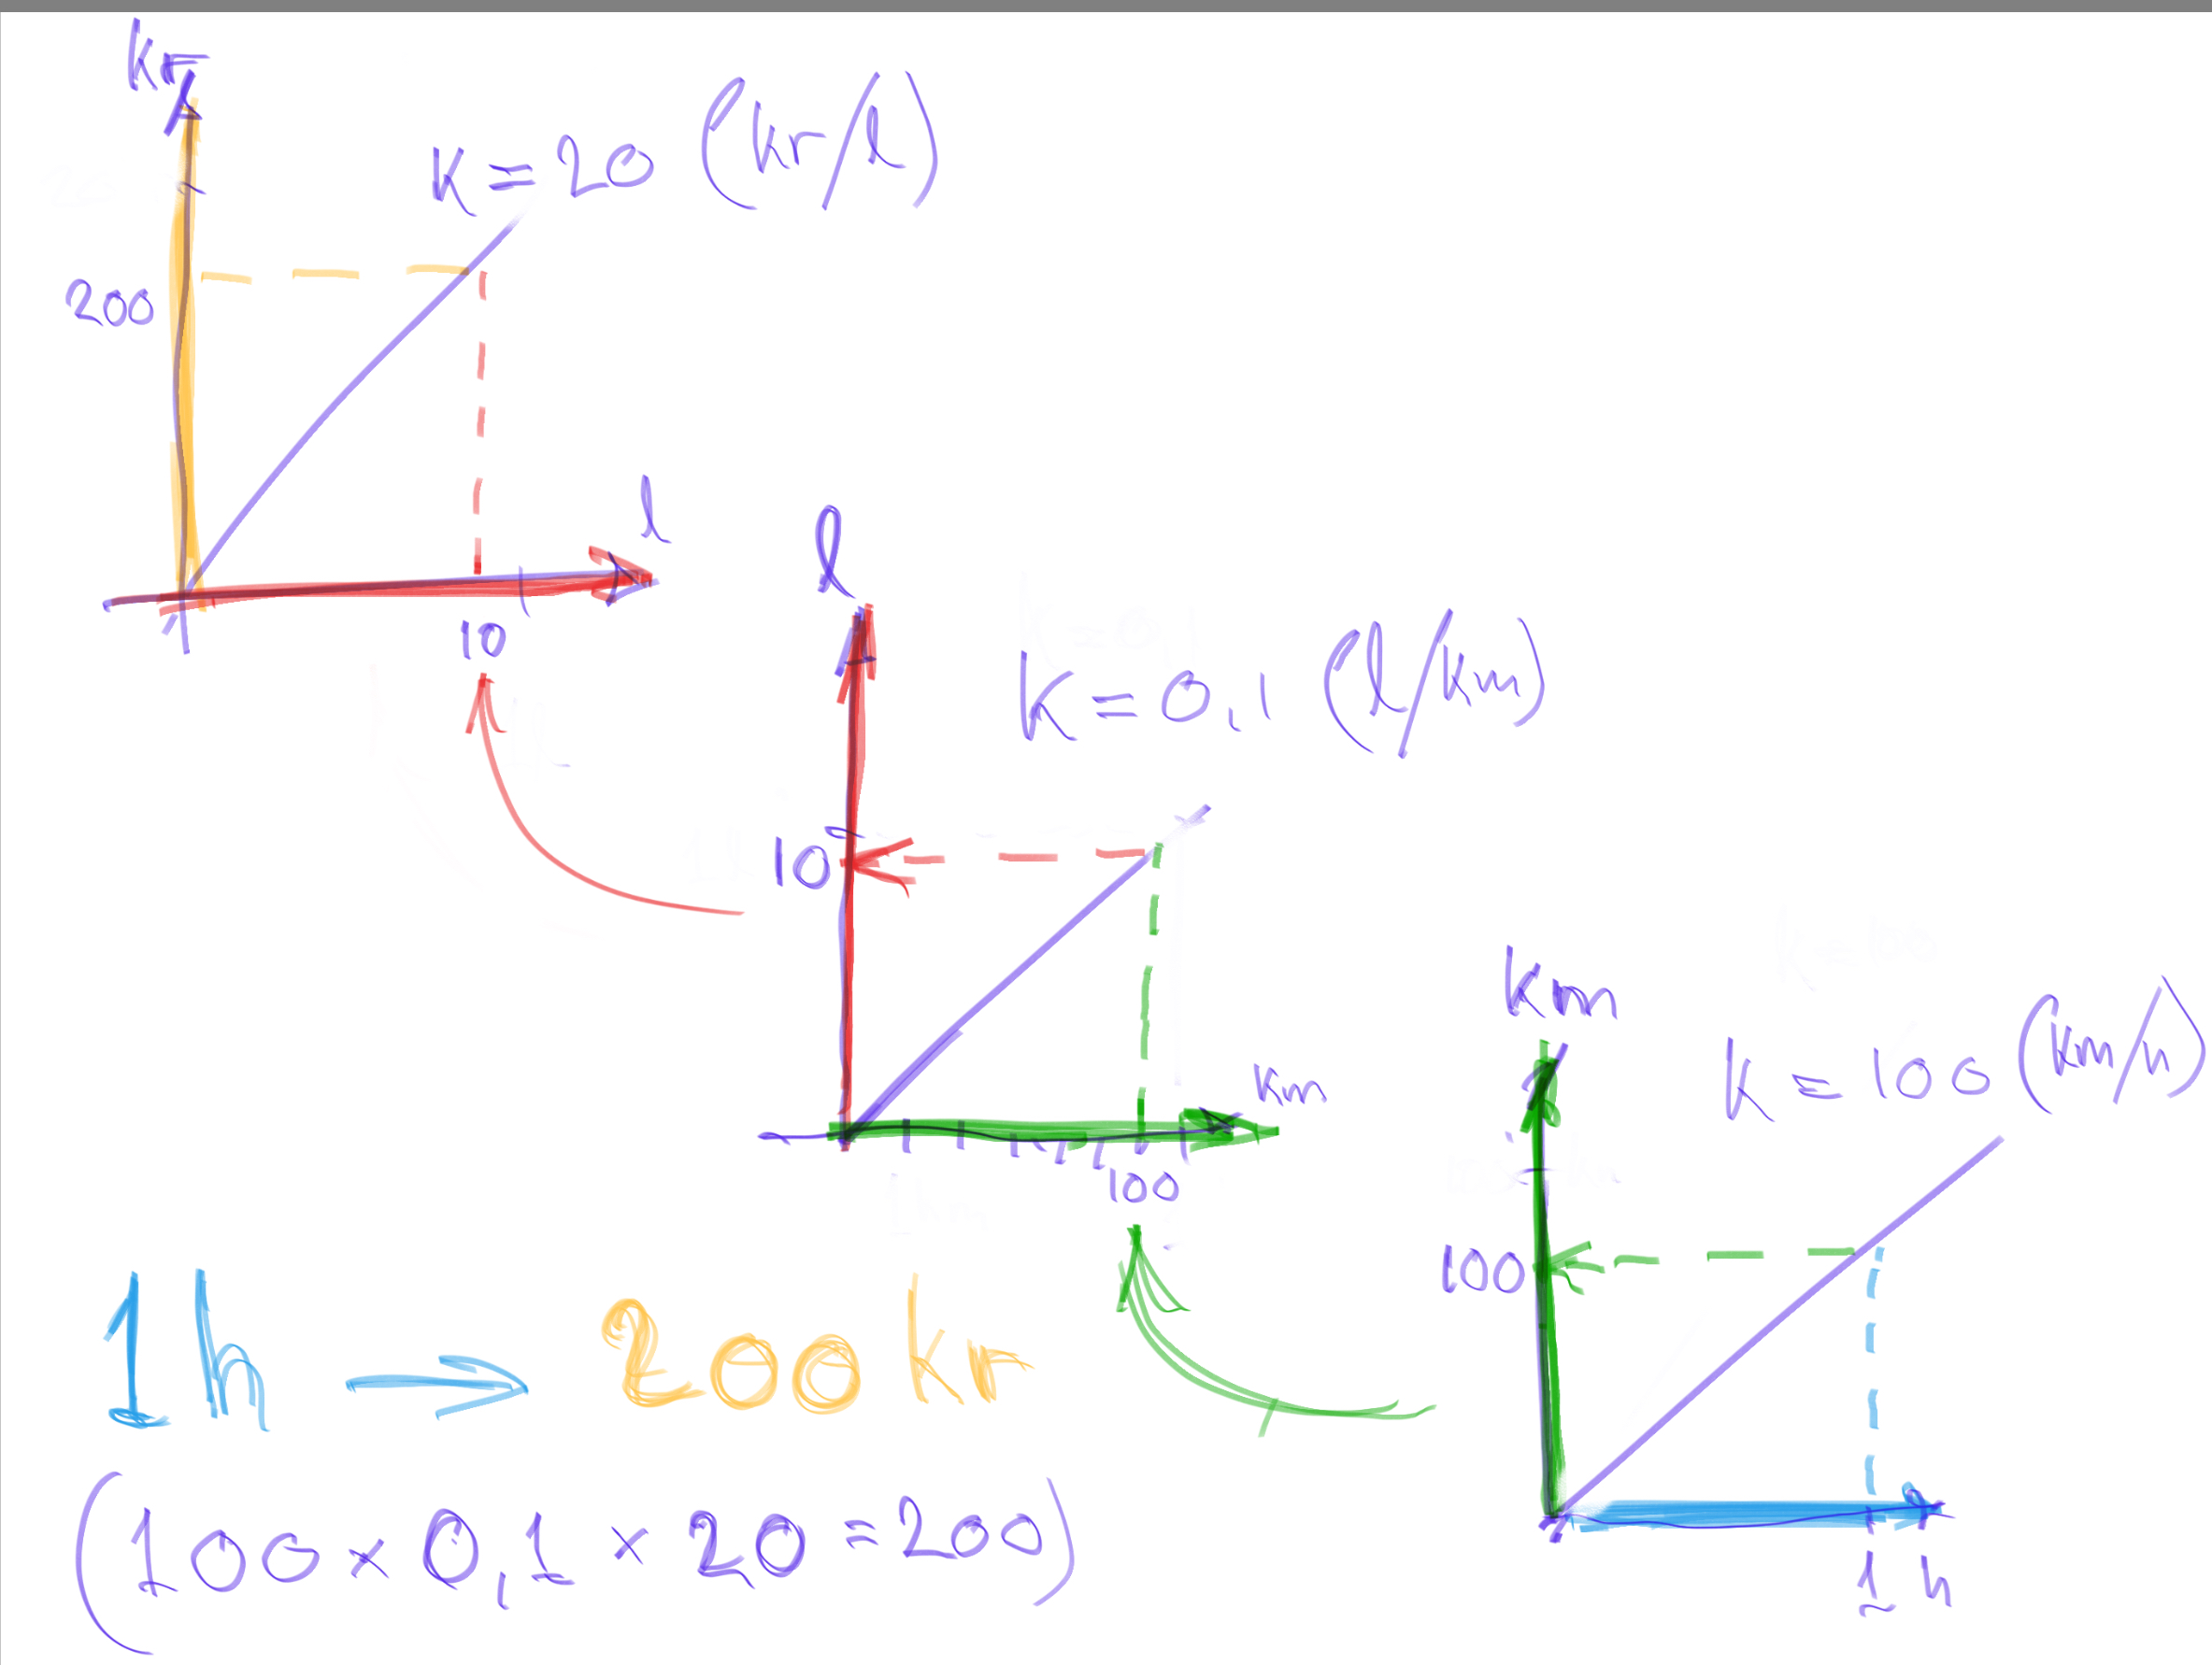

In [102]:
Image("backprop_bil.jpg", width=500, height=350)

$$\require{cancel}$$

En liten förändring $dh$ (på tid-sträcka grafen) ger till slut upphov till en förändring $dKr$ (på liter-kr grafen) som vi ser ovan ($d$:et står för differens i y eller x-led). Men eftersom vi står på "den andra sidan" alltså vid $Kr$-axeln (vår Loss-function) så har vi endast tillgång till hur mycket fel vi vill rätta till. Inte hur stort $dh$ det ska till för att uppnå det.   

T.ex för att ändra $Kr$ med _27_ - och _endast_ genom att ändra $h$ en viss okänd mängd - skall vi hitta ett tal $h$ som multiplicerat med faktorn $\frac{dKr}{dh}$ blir _27_  ... men ajajaj den faktorn har vi ju inte(!) För att hitta den behöver gå baklänges genom systemet och beräkna alla enskilda k-värden på vägen:

$$\frac{dKr}{dl} = 20,  \frac{dl}{dKm} = 0.1,  \frac{dKm}{dh} = 100$$

... och multplicera ihop dem alla för att få fram $\frac{dKr}{dh}$. Detta kallas kedjeregeln, och funkar även för krångliga funktioner som inte bara är rätta linjer som i detta exempel.   
Så nu har vi sambandet:
$$\frac{dKr}{dh} = 200 \Leftrightarrow dh=\frac{dKr}{200}$$
Alltså behöver vi förändra $h = \frac{27}{200}=0.135$ timmar.

Som bonusförklaring kan vi konstatera att rent algebraiskt blir det också tydligt att:<br>$$\frac{dKr}{\cancel{dl}}\cdot\frac{\cancel{dl}}{\cancel{dKm}}\cdot\frac{\cancel{dKm}}{dh}=\frac{dKr}{dh}$$



Ja, matte funkar faktiskt så, även för differentialer (som används till derivator) men det ses bara om man använder Leibnizs notation för derivata $\frac{dy}{dx}(=k-värdet)$ men inte Newtons $f'(x)$






***

### Övning ###
###### I siffer-manipulering och grafritande ######

* Gör en lista x = [ ... ] fylld med slumptal mellan -2 och 2. Typ 20 lång
* Gör en lika lång lista $y$, där varje $y_n = kx_n + m$, där du själv väljer _k_ och _m_ värdena, som ska vara samma för alla beräknade $y$.
* Använd paketet "matplotlib" för att rita en x-y graf  
_Du kan komma behöva installera det lite beroende på vilken programmeringsmiljö du använder, typ PyCharm, vsCode, Jupyter Notebook, google Colab, etc ... Här i notebook räcker "!pip install matplotlib", som jag gjort ovan_
* När du fått datorn att rita en hygglig graf/plot på x o y, gör en ny lista z, där varje värde är en linjär funktion av x, med nya _k_ och _m_ - värden (också förslagsvis mellan -2 och 2), fast denna gång ska även dessa slumpas för _varje_ element du beräknar till z-listan. Dvs $z=[k_1x_1+m_1, k_2x_2+m_2, ... ]$
* Plotta z-listan i samma graf som ovan. Tipset är att använda en funktion (i matplotlib) som heter "scatter". Experimentera och lär(!)   
_(z ska alltså ses som alternativa y-värden och _inte_ som en ny dimension till nån 3D figur, eller nåt)_ 


***
***

### Implementering ###

In [10]:
import numpy as np
import random

# Så att det finns ett _minimum-loss_ att eftersträva
def abs_loss(y_sann, y_gissn):
    return abs(y_sann - y_gissn)

def line(x):       # Här och bara här bestäms linjens ekvation
    return -3*x-1  # Det _riktigt_ sanna svaret, själva linjen. 

def facit(x):
    global rng   # Normalfördelat brus = större avstånd från linjen, dess färre
    noise= rng.normal(0, 2.0)     # Bygger på lite brus på "facit", så vi kan visa att ..
    return line(x) + noise        # .. nätverket kan hitta den bästa linjen i.a.f

#samla statistic
Xs = []      # Denna kommer att fyllas med x-värden vi använt
Ys = []      # .. och denna med (noisy / brusiga) y-värden
Zs = []       # .. och denna med nätverkets gissningar / prediktioner för varje x
y_line = []  # .. och denna med de värden PÅ linjen, så vi kan rita den
rng = np.random.default_rng(12345)  # Skapar en mer avancerad slumgenerator än 'random'

def samlaStat(x, y, z):
    global Xs, Ys, Zs
    Xs.append(x)
    Ys.append(y)
    Zs.append(z)

# Träningsdata förbereds
random.seed(42)  # For reproducerbarhet när vi jämför varandras program
num_samples = 500   #så här många x-gissningar ska vi träna med

# Initialize weights and bias
w = random.uniform(-1,1)
b = random.uniform(-1,1)

# Träningsparametrar så den inte går för snabbt o flippar ut
learning_rate = 0.01

# Träningsloop
for num in range(num_samples):
    
    x = random.uniform(-1,1) * 5 # slumpa ett x mellan -5 och 5
    
    y_sann = facit(x)   # obs, med brus
    
    # Forward pass
    Zum = x * w + b # Slutliga gissningen, som ska jämföras med facit (y_sann)

    # Beräkna loss
    loss = abs_loss(y_sann, Zum)

    ######### Back prop --- Start #########
    
    # Baklänges pass - beräkna totalt k-värde / derivatan / lutningen m.h.a kedjeregeln
    
    dLoss_dyGiss = 1 if Zum > y_sann else -1 # K-värdet på abs-funk är ju antingen 1 eller -1
    
    dLoss_dw = dLoss_dyGiss * x  # *x, eftersom det ju är w som är vår variabel, inte x
                        # .. så det blir x:et som är k-värdet i y = x*w + b, vad angår w
        
    dLoss_db = dLoss_dyGiss * 1 # Och 1 som blir k-värdet, vad angår b (*1 är för syns skull)
    
    # Uppdatera weights & bias
    w -= learning_rate * dLoss_dw
    b -= learning_rate * dLoss_db
    
    ######### Back prop --- Slut #########
    
    n = 2
    if num % n == 0:      # Spara på var n:te datapunkt (% = modolus, läs själv) 
        samlaStat(x, y_sann, Zum)# x och y_sann (med lite random noise) samt gissningen (Zum)
        y_line.append(line(x))   # ... och y_line (som är exakt på linjen)
        
    if num % 100 ==0:     # Skriv ut, litet då och då, hur stort felet är (ska helst minska)
        print(f"ant_x {num}, Loss: {loss:.4f}")

# Detta ska jämföras med facit-funktionen f(x) = 3*x + 2 = w*x + b
print(f"Färdigtränad weight: {w}")
print(f"tränad bias: {b}")

ant_x 0, Loss: 4.4788
ant_x 100, Loss: 1.9645
ant_x 200, Loss: 5.0573
ant_x 300, Loss: 0.1065
ant_x 400, Loss: 3.5586
Färdigtränad weight: -2.9687481036953045
tränad bias: -0.9499784895546661


In [12]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 6.1 MB/s eta 0:00:0000:0100:01
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)


### Sen plottar vi vad vi samlat in ### 

##### Fast nu i en motsvarighet till Matplotlib, Plotly #####

In [11]:
!pip install plotly #Installera först

In [13]:
### PLOTLY Time ####
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np

import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
#import plotly.io as pio
import ipywidgets as widgets
#pio.renderers.default = "colab"

index_normalized = np.linspace(0, 1, len(Xs))

# Create the plotly figure
fig = go.FigureWidget()

scatter1 = go.Scatter(x=Xs, y=Ys, mode='markers', marker=dict(color='green', size=4), name='Scatter 1')
line_plot = go.Scatter(x=Xs, y=y_line, mode='lines', line=dict(color='black'), name='y=kx+m - linjen')


colorbar_dict = dict(
    title='Index',
    len=0.75,
    y=0.4 # Adjust the y value to move the colorbar down
)

scatter2 = go.Scatter(
    x=Xs,
    y=Zs,
    mode='markers',
    marker=dict(
        color=index_normalized,
        colorscale='Viridis',
        showscale=True,
        size=6,
        colorbar=colorbar_dict
    ),
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Scatter 2'
)


fig.add_trace(scatter1)
fig.add_trace(line_plot)
fig.add_trace(scatter2)

fig.update_xaxes(range=[-5, 5])
fig.update_yaxes(range=[-25, 25])
fig.update_layout(height=600)

# Add the color bar to the layout
fig.update_layout(coloraxis_colorbar=colorbar_dict)



# Slider widget
slider = widgets.IntSlider(min=0, max=len(Xs) - 1, step=1, description="Frame:")
slider.layout.width = '80%'

# Function to update the plot based on slider value
def update_plot(change):
    i = change["new"]
    with fig.batch_update():
        fig.data[2].x = Xs[:i + 1]
        fig.data[2].y = Zs[:i + 1]
        fig.data[0].y = Ys[:i + 1]
        fig.data[2].marker.colorbar = colorbar_dict

# Link slider to the update function
slider.observe(update_plot, names="value")


display(fig)
#fig.show(renderer = 'colab')   # Avkommentera denna (o kommentera bort ovan) ifall du kör Goolge colab
display(slider)


FigureWidget({
    'data': [{'marker': {'color': 'green', 'size': 4},
              'mode': 'markers',
              'name': 'Scatter 1',
              'type': 'scatter',
              'uid': '43480a85-649f-4582-95e1-86ba4ea3c11d',
              'x': [-2.2497068163088074, 2.364712141640124, 3.921795677048454,
                    ..., -0.9568333086236291, -0.3260985076768985,
                    1.2225696097406469],
              'y': [2.9014703760171603, -9.835459900838543, -12.916073645166405,
                    ..., 2.402459018206085, 2.6411025102641332, -4.710425436108981]},
             {'line': {'color': 'black'},
              'mode': 'lines',
              'name': 'y=kx+m - linjen',
              'type': 'scatter',
              'uid': '622a82f3-160d-4b4e-b7da-3234543fc00e',
              'x': [-2.2497068163088074, 2.364712141640124, 3.921795677048454,
                    ..., -0.9568333086236291, -0.3260985076768985,
                    1.2225696097406469],
              'y': 

IntSlider(value=0, description='Frame:', layout=Layout(width='80%'), max=249)